In [7]:
!pip --version

pip 22.0.4 from D:\miniconda\envs\base2\lib\site-packages\pip (python 3.7)



# 1.MLP

## 1.下载数据和环境

colab上使用，其中AAA是目录
```
def colab_download(proj_name):
    import requests

    project_name=proj_name

    url = f'http://kuroweb.tk:8000/api/v1/pack/wyftp/dataset/{project_name}.tar.gz'
    user, password = 'wuying', '123aaa'
    resp = requests.get(url, auth=(user, password))
    # write to file
    with open('download.tar.gz', 'wb') as f:
        f.write(resp.content)
    import tarfile

    # open file
    file = tarfile.open('download.tar.gz')
    # extracting file
    file.extractall('./')
    file.close()

    import shutil
    import os

    source_dir = f'./{project_name}'
    target_dir = './'

    file_names = os.listdir(source_dir)

    for file_name in file_names:
      try:
        shutil.move(os.path.join(source_dir, file_name), target_dir)
      except Exception as e:
        print(e,'at',file_name)
```

## 如果是kaggle，要另外加上
```
import sys
sys.path.append("/kaggle/working/")
```

In [8]:
def colab_download(proj_name, is_kaggle):
    import requests
    from tqdm import tqdm

    if is_kaggle:
        import sys
        sys.path.append("/kaggle/working/")

    project_name = proj_name

    url = f'http://kuroweb.tk:8000/api/v1/pack/wyftp/dataset/{project_name}.tar.gz'
    user, password = 'wuying', '123aaa'
    response = requests.get(url, stream=True, auth=(user, password))
    total_size_in_bytes = int(response.headers.get('content-length', 0))
    block_size = 1024  #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open('download.tar.gz', 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

    import tarfile

    # open file
    file = tarfile.open('download.tar.gz')
    # extracting file
    file.extractall('./')
    file.close()

    import shutil
    import os

    source_dir = f'./{project_name}'
    target_dir = './'

    file_names = os.listdir(source_dir)

    for file_name in file_names:
        try:
            shutil.move(os.path.join(source_dir, file_name), target_dir)
        except Exception as e:
            print(e, 'at', file_name)



In [9]:
# colab_download('model',True)
# !pip install -r requirements.txt

In [10]:
import seaborn as sns

import os.path
from general_model.grow_numpy import GrowableNumpyArray
from general_model.list_batch_loader import ListBatchLoadDataset
from torch.utils.data import Dataset, DataLoader

from tool import ml
import os
from tool import wine_tool
import pandas as pd
from IPython.display import display
from collections import OrderedDict

import torch.nn as nn

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

import random
import torch.nn.functional as F
from general_model.layers import LambdaLayer
from tool.dbg import dbg
from tool import wine_data_loader
from model_helper.singlecudatrainer import SingleCudaTrainer
from model_helper.single_gpu_dataloader import SingleGpuTensorWrapper
from pytorch_classify.params import ClassifyParams
import tool.tflite_converter as tflite_converter
from pytorch_regression.regression_params import RegressionParams
import pytorch_regression
import importlib


D:\miniconda\envs\base2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:

wine_json = ml.read_json("Wine.json")
wine_json

[{'name': '酒精',
  'id': '#102',
  'degree': 75.0,
  'items': [{'name': '#1', 'degree': 70.5},
   {'name': '#2', 'degree': 62.04},
   {'name': '#3', 'degree': 55.84},
   {'name': '#4', 'degree': 50.25},
   {'name': '#5', 'degree': 45.23},
   {'name': '#6', 'degree': 37.99},
   {'name': '#7', 'degree': 30.39},
   {'name': '#8', 'degree': 21.27},
   {'name': '#9', 'degree': 12.76},
   {'name': '#10', 'degree': 7.66},
   {'name': '#11', 'degree': 1.53}]},
 {'name': '国之娇子',
  'id': '#101',
  'degree': 53.0,
  'items': [{'name': '#1', 'degree': 50.88},
   {'name': '#2', 'degree': 47.83},
   {'name': '#3', 'degree': 44.96},
   {'name': '#4', 'degree': 41.36},
   {'name': '#5', 'degree': 37.22},
   {'name': '#6', 'degree': 33.5},
   {'name': '#7', 'degree': 26.8},
   {'name': '#8', 'degree': 19.3},
   {'name': '#9', 'degree': 11.58},
   {'name': '#10', 'degree': 6.95}]},
 {'name': '北京二锅头', 'id': '#1', 'degree': 42.0, 'items': []},
 {'name': '威海卫烧锅', 'id': '#2', 'degree': 40.0, 'items': []},
 {

# data4数据集加载

需要设置批处理大小

----------------
调参

In [21]:
param = RegressionParams()
param.batch_size = 64
param.epoch = 5000
param.lr = 1e-6
param.cnn_stride = 5
param.cnn_size = 3
param.pool_size = 5
param.lr_decay = 0.99
param.train_test_split= 0.8
param.activation = nn.Tanh()

D:\miniconda\envs\base2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
D:\miniconda\envs\base2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


酒精
{'name': '#1', 'degree': 70.5}
{'name': '#2', 'degree': 62.04}
{'name': '#3', 'degree': 55.84}
{'name': '#4', 'degree': 50.25}
{'name': '#5', 'degree': 45.23}
{'name': '#6', 'degree': 37.99}
{'name': '#7', 'degree': 30.39}
{'name': '#8', 'degree': 21.27}
{'name': '#9', 'degree': 12.76}
{'name': '#10', 'degree': 7.66}
{'name': '#11', 'degree': 1.53}
国之娇子
{'name': '#1', 'degree': 50.88}
{'name': '#2', 'degree': 47.83}
{'name': '#3', 'degree': 44.96}
{'name': '#4', 'degree': 41.36}
{'name': '#5', 'degree': 37.22}
{'name': '#6', 'degree': 33.5}
{'name': '#7', 'degree': 26.8}
{'name': '#8', 'degree': 19.3}
{'name': '#9', 'degree': 11.58}
{'name': '#10', 'degree': 6.95}
北京二锅头
威海卫烧锅
丁香情
原浆
北大仓
苦芥
五粮情
not exists: data4/#13
景芝白干
衡水老白干
老酒壶
牛栏山陈酿
杜二酒
小郎酒
闷倒驴
not exists: data4/#14
牛栏山二锅头
not exists: data4/#15


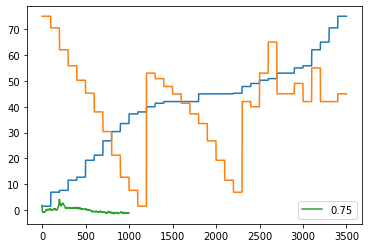

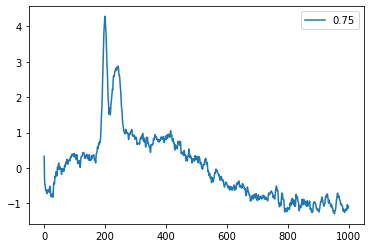

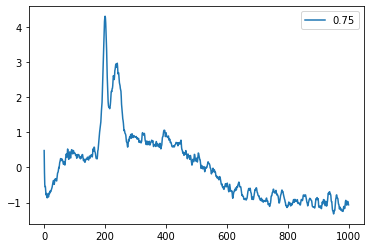

In [13]:
x = GrowableNumpyArray(dtype=np.float, grow_speed=16)
y = GrowableNumpyArray(dtype=np.float, grow_speed=16)

for wine in wine_json:
    base_wine_path = 'data4/' + wine['id']
    dbg(wine['name'])
    if not os.path.exists(base_wine_path):
        dbg('not exists:', base_wine_path)
        continue
    # load data
    dirs = ml.getAllFiles(f'{base_wine_path}')
    for d in dirs:
        path = d
        files = ml.getAllFileRecursively(path)
        for f in files:
            x.update(wine_tool.col2data_to_float_list(f))
            y.add(wine['degree'])
            # x = np.append(x, wine_tool.col2data_to_float_list(f))
            # y = np.append(y, wine['degree'])

    # load item_data
    for wine_item in wine['items']:
        sub_wine_path = base_wine_path + '_' + wine_item['name']

        dirs = ml.getAllFiles(f'{sub_wine_path}')
        dbg(wine_item)
        for d in dirs:
            path = d
            files = ml.getAllFileRecursively(path)
            for f in files[:100]:
                x.update(wine_tool.col2data_to_float_list(f))
                y.add(wine_item['degree'])
                # x = np.append(x, wine_tool.col2data_to_float_list(f))
                # y = np.append(y, wine_item['degree'])

x = x.finalize()
x = x.reshape((-1, 1000))

y = y.finalize()

plt.plot(sorted(y))
plt.plot(y)

# normalize

y = y / 100

layer_normed_x = torch.nn.LayerNorm([1000])(torch.tensor(x, dtype=torch.float))
i = 0
while i < 3:
    indice = i
    plt.plot(layer_normed_x[indice].detach().numpy(), label=y[indice])
    plt.legend()
    plt.show()
    i += 1

numpy_x, numpy_y, numpy_x1, numpy_y1 = wine_data_loader.split(x, y, 1 - param.train_test_split)

In [14]:
x_gpu_wrapper = SingleGpuTensorWrapper(torch.from_numpy(numpy_x).float(), param.use_gpu)
y_gpu_wrapper = SingleGpuTensorWrapper(torch.from_numpy(numpy_y).float(), param.use_gpu)
x1_gpu_wrapper = SingleGpuTensorWrapper(torch.from_numpy(numpy_x1).float(), param.use_gpu)
y1_gpu_wrapper = SingleGpuTensorWrapper(torch.from_numpy(numpy_y1).float(), param.use_gpu)

wine_dataset = ListBatchLoadDataset(x_gpu_wrapper.tensor, y_gpu_wrapper.tensor)
dataloader = DataLoader(wine_dataset, batch_size=param.batch_size,
                        shuffle=True, num_workers=0)

In [15]:
x1_gpu_wrapper.tensor.shape,x_gpu_wrapper.tensor.shape

(torch.Size([700, 1000]), torch.Size([2800, 1000]))

In [29]:
class MlpRegression(nn.Module):

    def __init__(self, param):
        super().__init__()
        self.norm = nn.LayerNorm([1000])
        self.layer1 = nn.Sequential(
            LambdaLayer(lambda x: x.view(-1,1, 1000)),
            nn.AvgPool1d(param.pool_size, stride=param.cnn_stride),
            nn.Linear(200, 1000),
            nn.Tanh(),
            nn.Linear(1000, 1),
        )

    def forward(self, x):
        x = self.norm(x)
        x = self.layer1(x)
        return x

In [23]:
dbg(MlpRegression(param))

MlpRegression(
  (norm): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
  (layer1): Sequential(
    (0): AvgPool1d(kernel_size=(5,), stride=(5,), padding=(0,))
    (1): Linear(in_features=200, out_features=1000, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=1000, out_features=1000, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=1000, out_features=1, bias=True)
  )
)


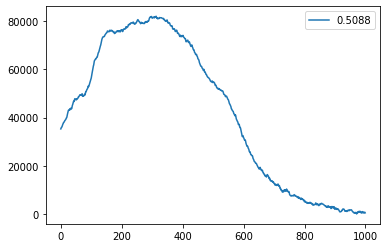

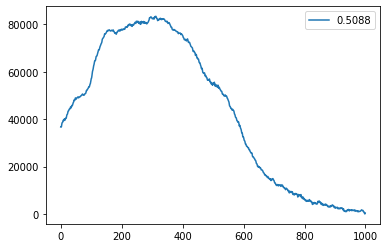

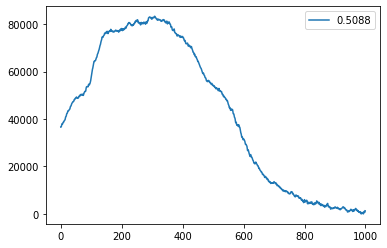

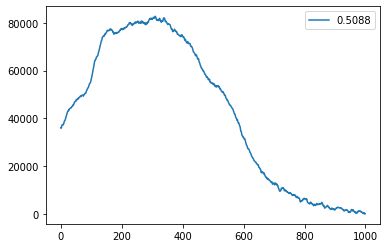

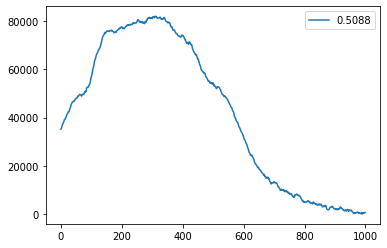

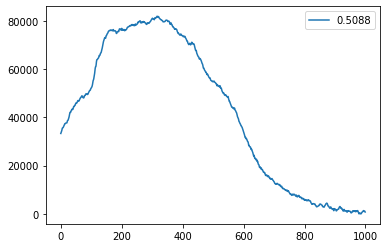

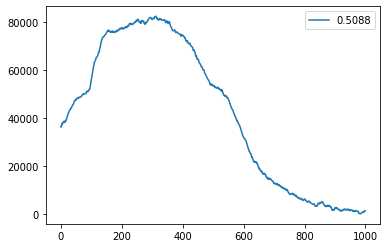

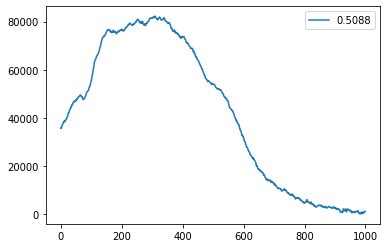

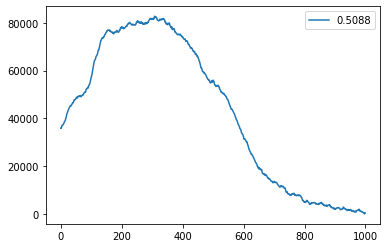

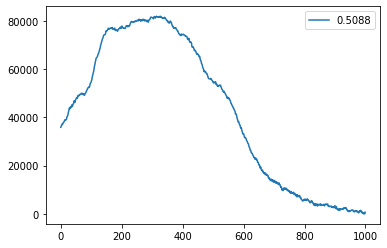

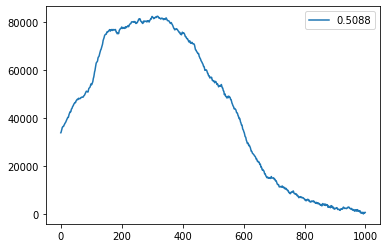

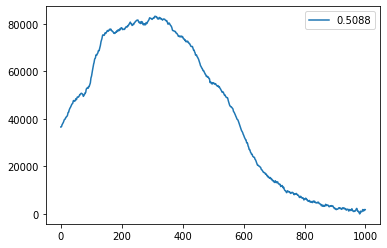

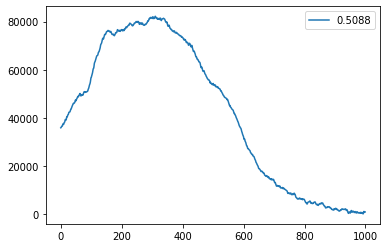

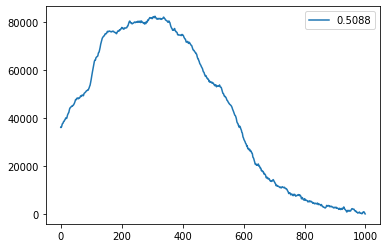

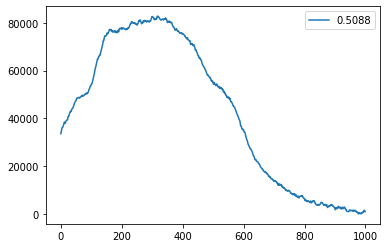

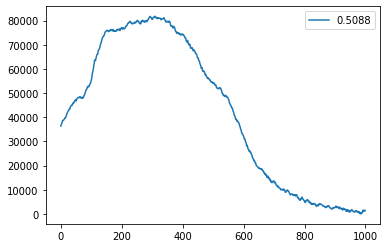

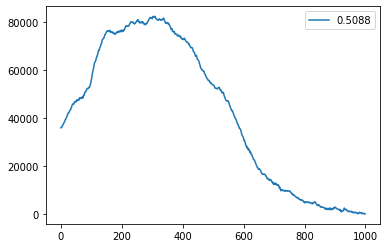

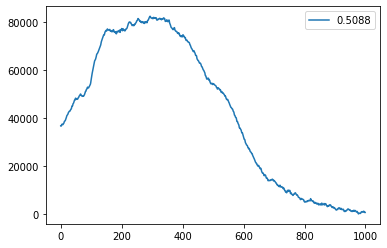

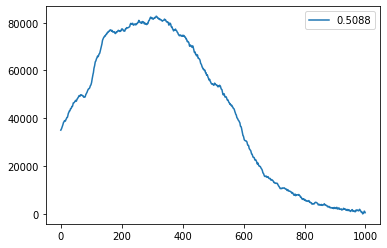

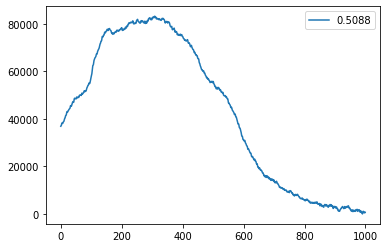

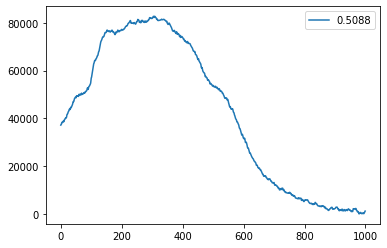

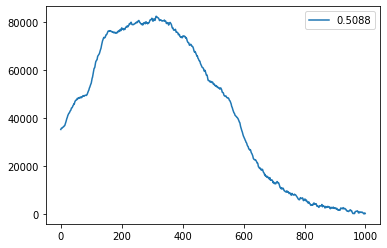

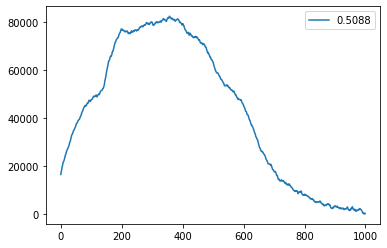

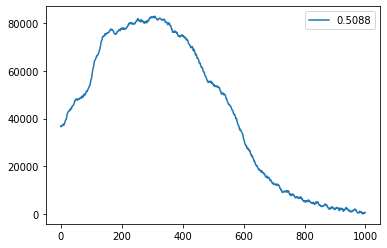

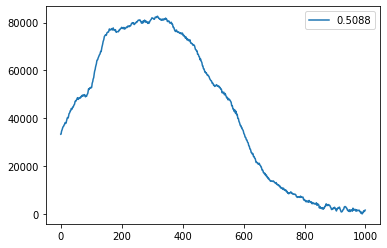

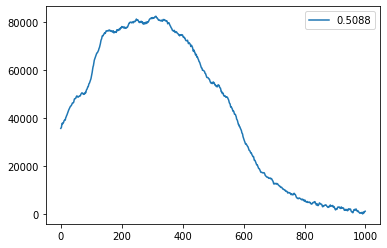

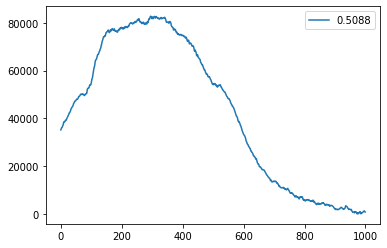

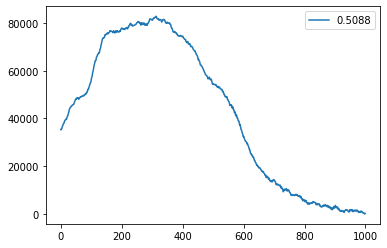

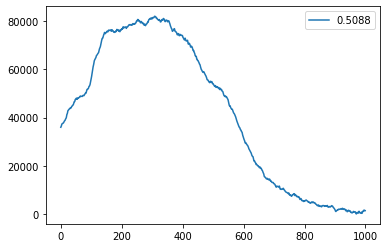

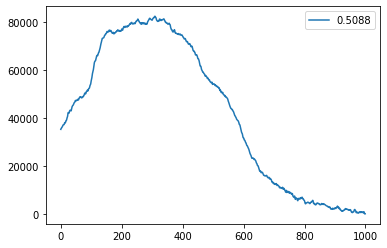

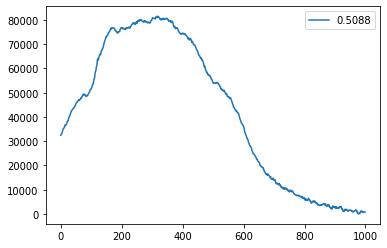

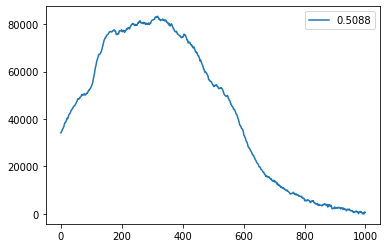

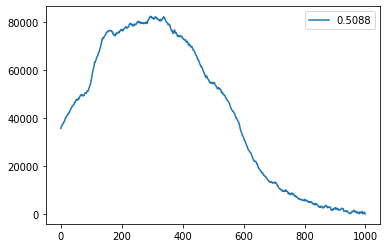

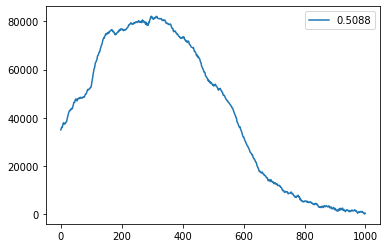

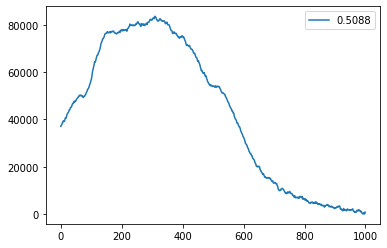

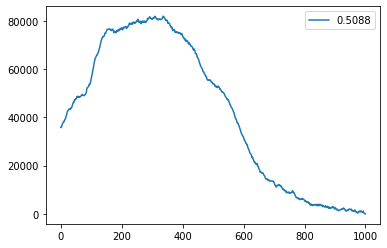

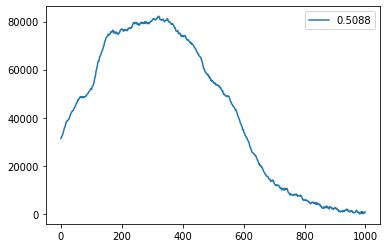

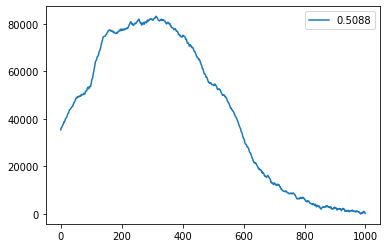

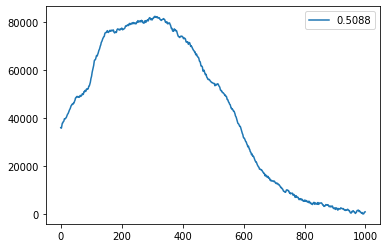

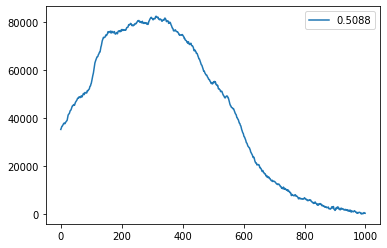

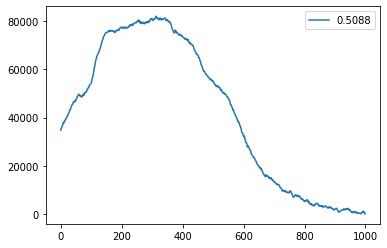

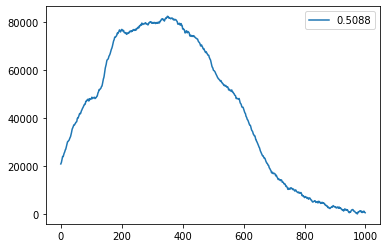

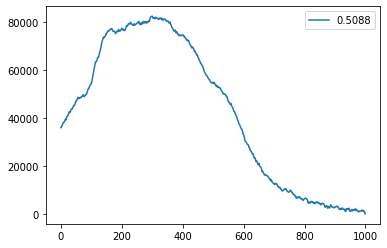

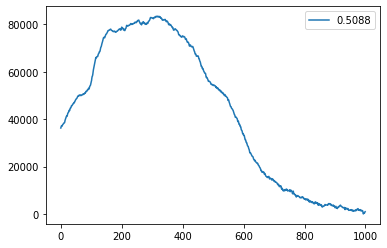

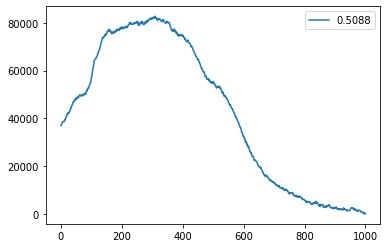

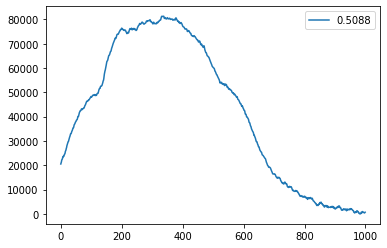

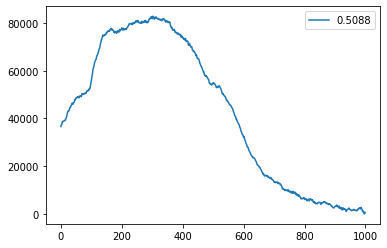

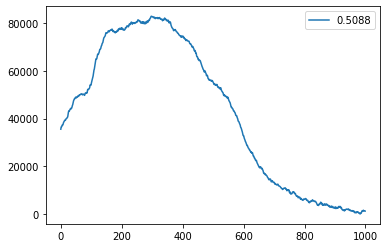

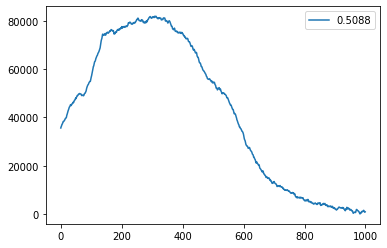

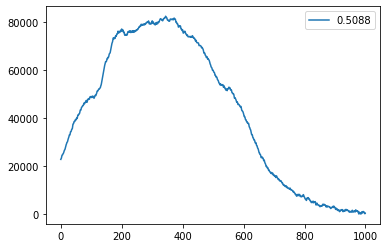

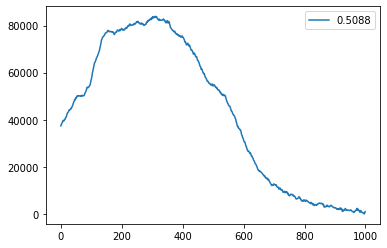

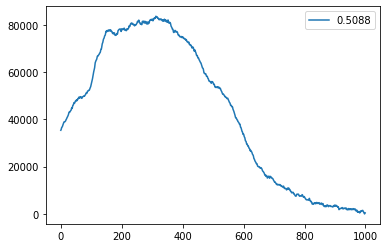

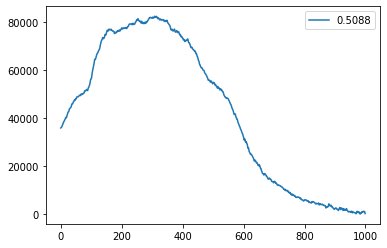

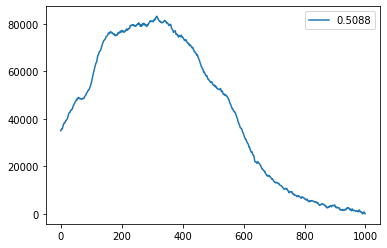

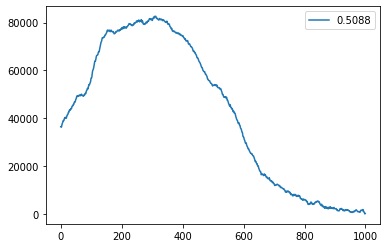

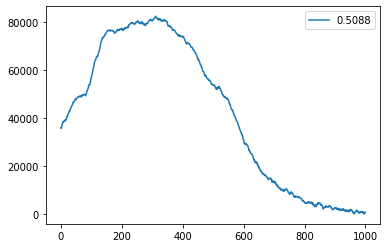

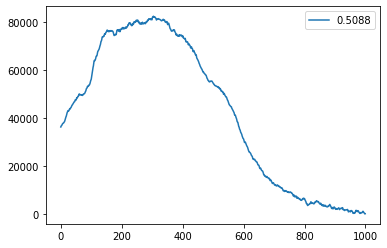

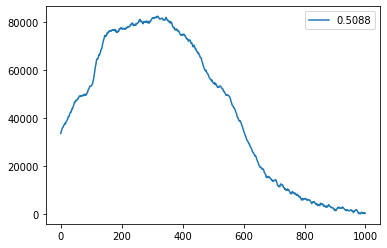

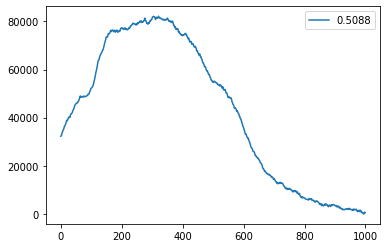

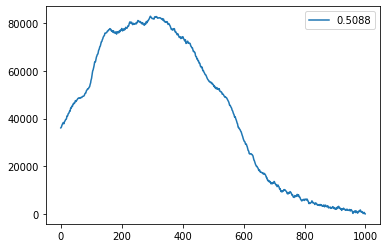

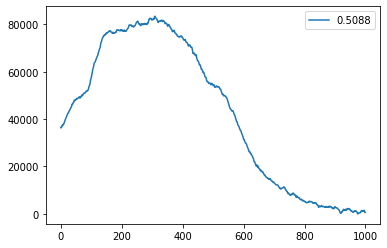

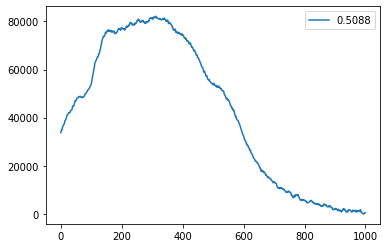

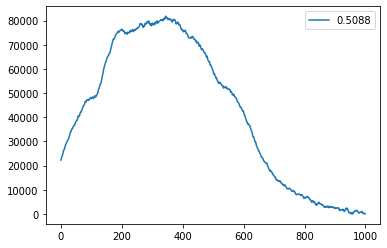

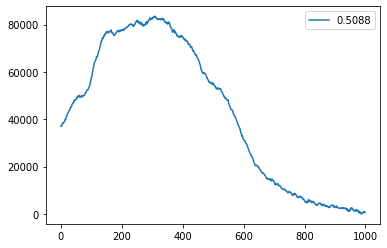

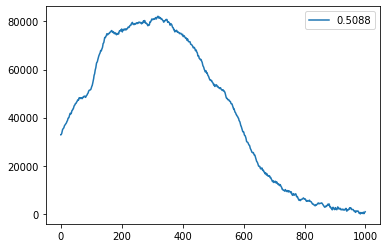

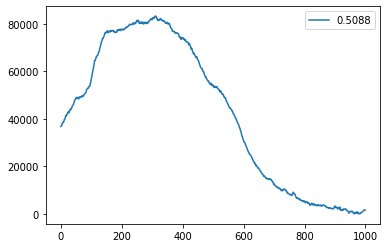

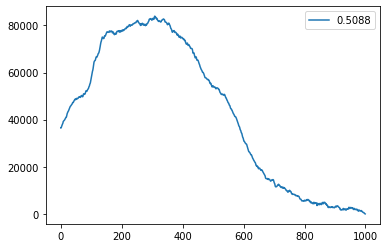

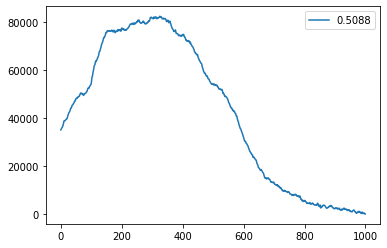

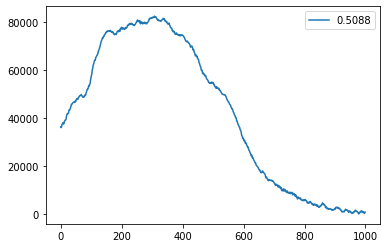

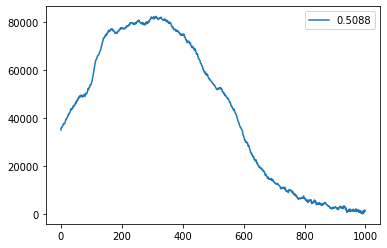

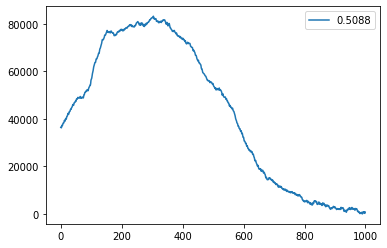

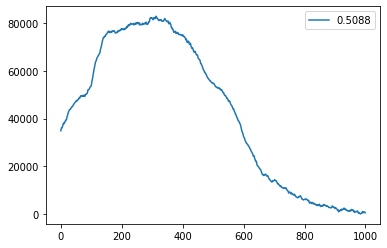

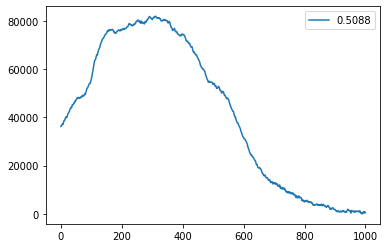

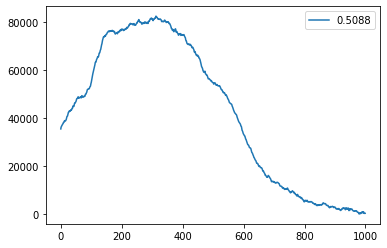

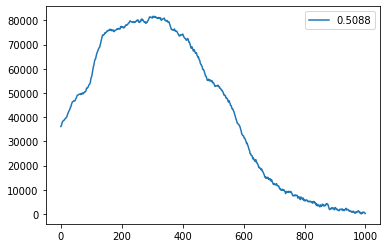

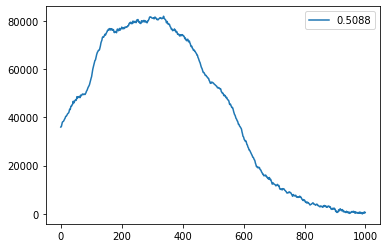

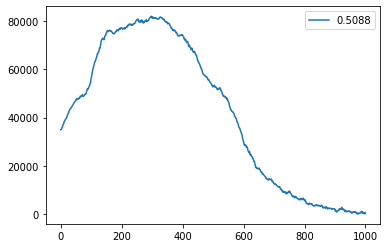

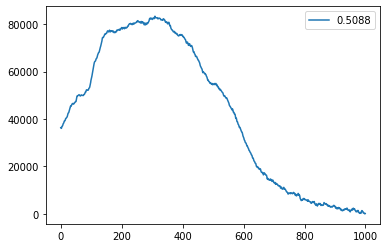

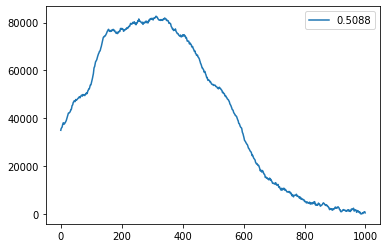

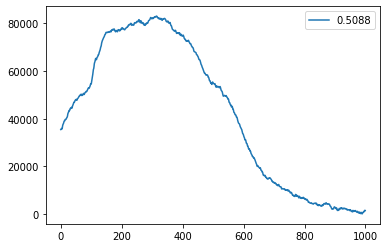

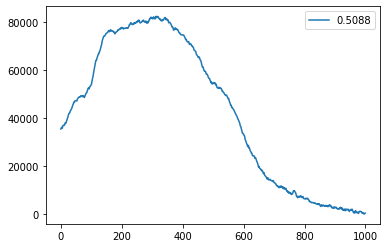

In [19]:
sum=0
for idx, dda in enumerate(dataloader):
    x, y = dda[0],dda[1]
    for i in range(x.shape[0]):
        x_item= x[i]
        # dbg(x_item.cpu().numpy())
        if y.cpu().detach().numpy()[i]>0.5080 and y.cpu().detach().numpy()[i]<0.5090:
            plt.plot(x_item.cpu().detach().numpy(), label=str(y.cpu().detach().numpy()[i]))
            plt.legend()
            plt.show()
    # break
# 数据集上应该不存在问题

iteration: 0 loss: 0.035626394377852026


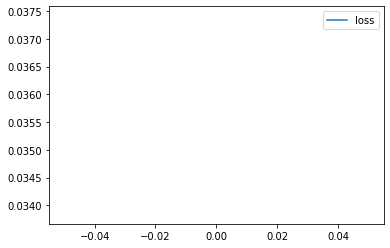

2.571428571428571
iteration: 50 loss: 0.034888803704895756


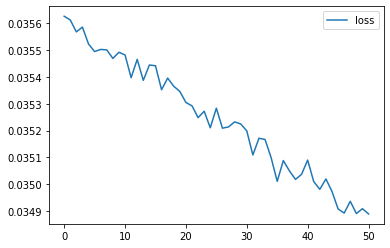

2.571428571428571
iteration: 100 loss: 0.034209249541163445


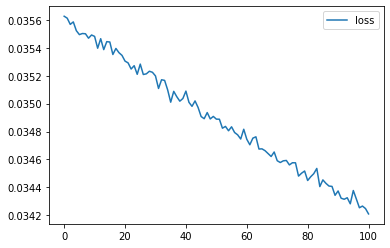

2.571428571428571
iteration: 150 loss: 0.033732017036527395


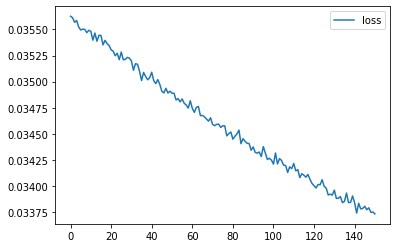

4.571428571428571
iteration: 200 loss: 0.03326802192763849


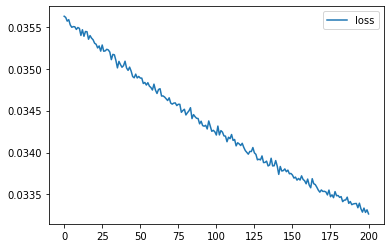

4.857142857142857
iteration: 250 loss: 0.03292336048219691


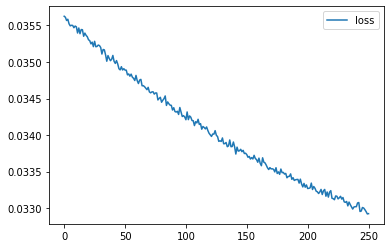

7.428571428571429
iteration: 300 loss: 0.03272279948842796


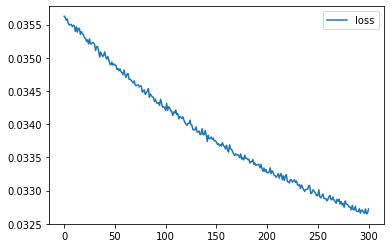

8.142857142857144
iteration: 350 loss: 0.0324042004279115


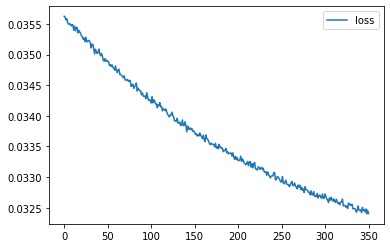

8.142857142857144
iteration: 400 loss: 0.03219196653332223


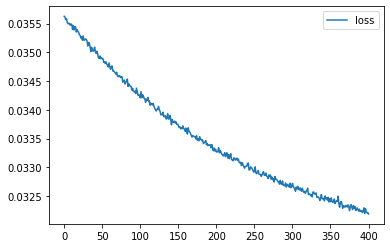

8.142857142857144
iteration: 450 loss: 0.03207379367879846


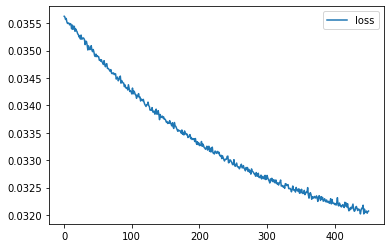

8.142857142857144
iteration: 500 loss: 0.031958635642447254


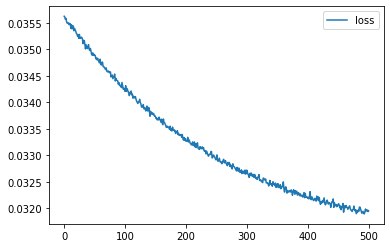

8.142857142857144
iteration: 550 loss: 0.031833337916230615


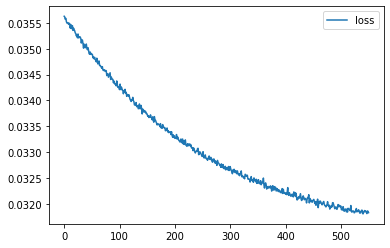

8.142857142857144
iteration: 600 loss: 0.03173045064745979


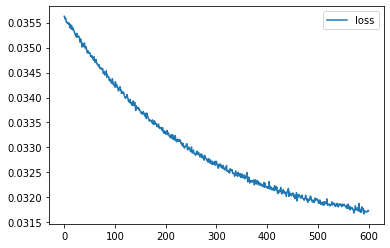

8.857142857142856
iteration: 650 loss: 0.03171007165854627


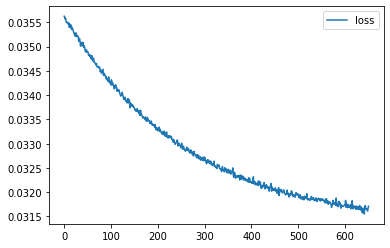

11.571428571428571
iteration: 700 loss: 0.031575238670815124


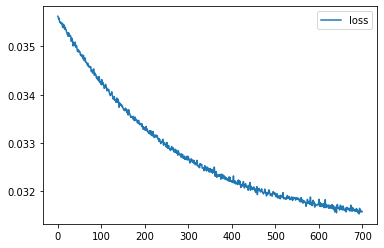

12.571428571428573
iteration: 750 loss: 0.03157608939165419


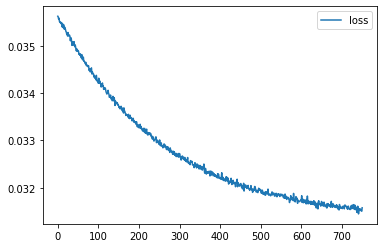

15.714285714285714
iteration: 800 loss: 0.03149481291290034


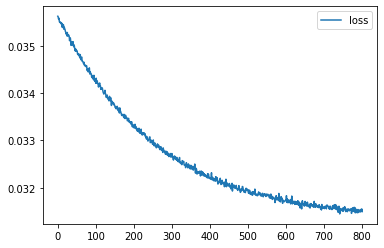

16.28571428571429
iteration: 850 loss: 0.031510982450775125


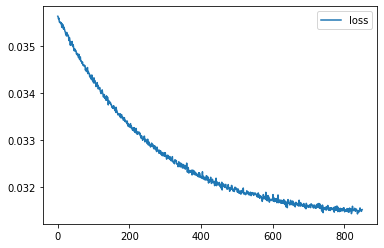

17.0
iteration: 900 loss: 0.031430743423036554


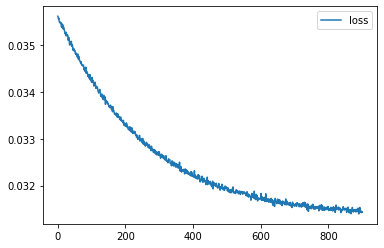

19.857142857142858
iteration: 950 loss: 0.03139652739363638


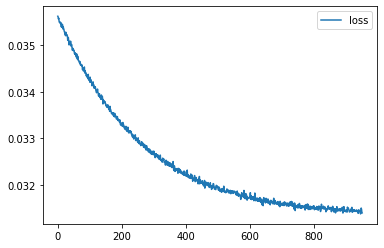

20.0
iteration: 1000 loss: 0.03138298930769617


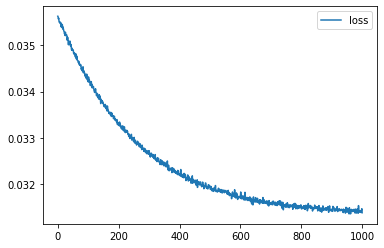

24.142857142857142
iteration: 1050 loss: 0.03138912854377519


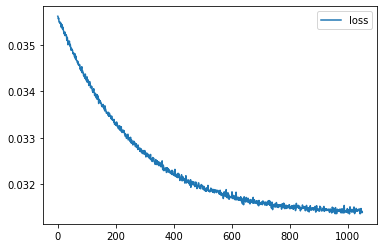

26.0
iteration: 1100 loss: 0.031391143036836926


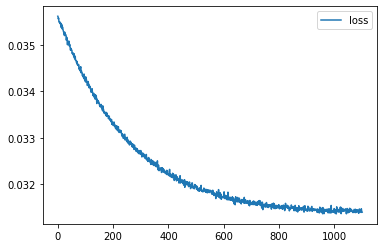

26.0
iteration: 1150 loss: 0.03136473686688326


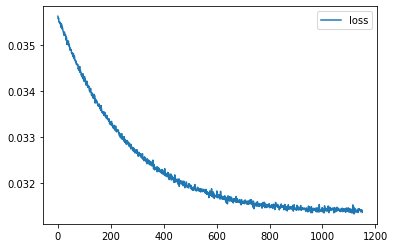

26.0
iteration: 1200 loss: 0.03139899446713654


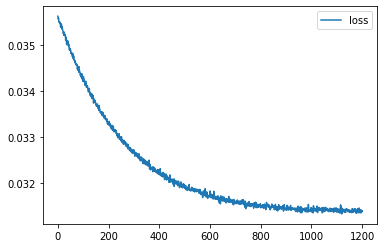

26.0
iteration: 1250 loss: 0.03140250834721056


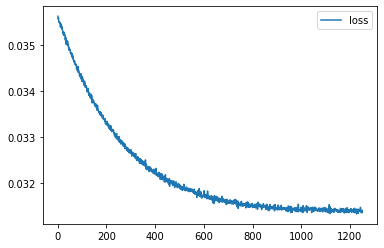

26.0
iteration: 1300 loss: 0.03136820811778307


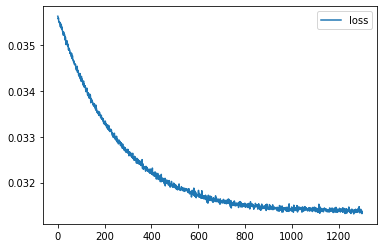

26.0
iteration: 1350 loss: 0.03136218889531764


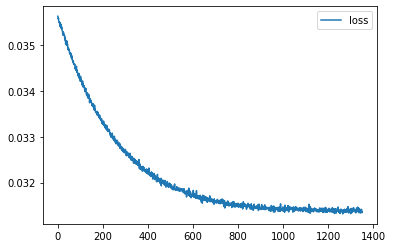

26.0
iteration: 1400 loss: 0.03139390356161378


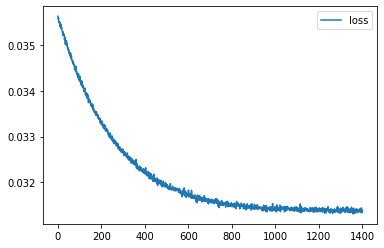

26.0
iteration: 1450 loss: 0.03136967880312692


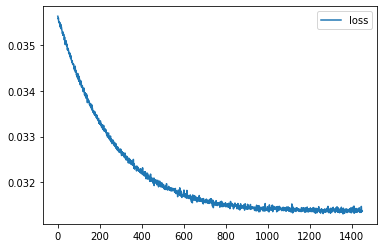

26.0
iteration: 1500 loss: 0.03137858406725255


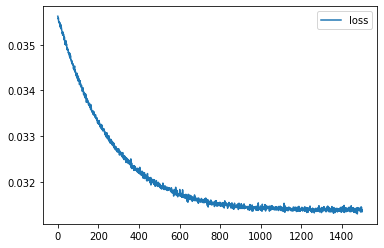

26.0
iteration: 1550 loss: 0.03136664015156301


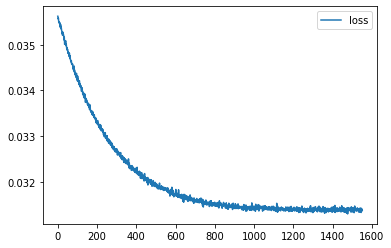

26.0
iteration: 1600 loss: 0.031372004908255556


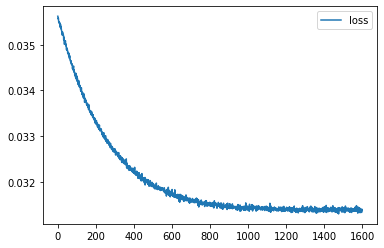

26.0
iteration: 1650 loss: 0.031391248614950615


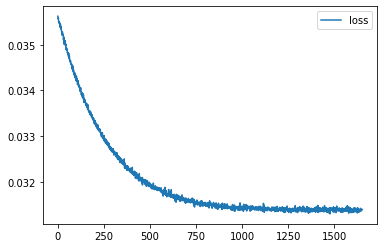

26.0
iteration: 1700 loss: 0.0313478845002299


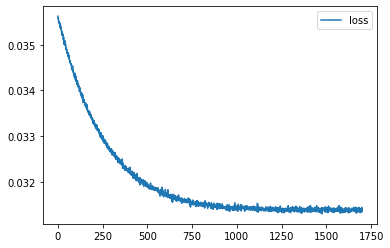

25.857142857142858
iteration: 1750 loss: 0.03137684173204682


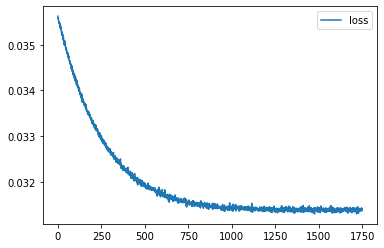

25.71428571428571
iteration: 1800 loss: 0.031314614694565535


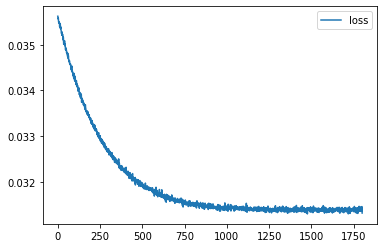

25.71428571428571
iteration: 1850 loss: 0.03136946375227787


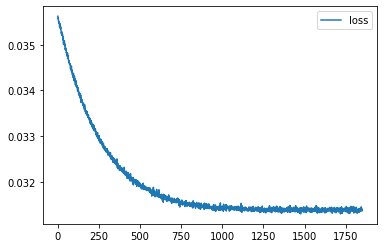

25.71428571428571
iteration: 1900 loss: 0.03139606660062617


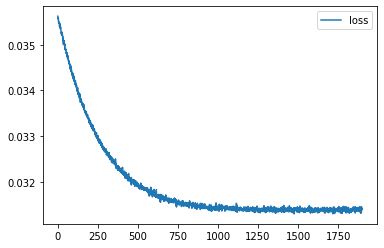

25.142857142857146
iteration: 1950 loss: 0.031332965855571354


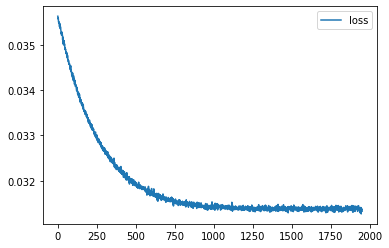

24.857142857142858
iteration: 2000 loss: 0.03143589211289178


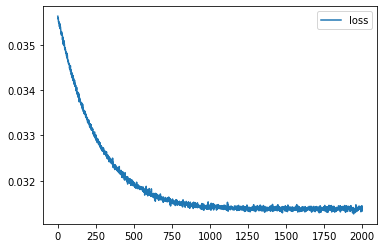

24.571428571428573
iteration: 2050 loss: 0.0313800666057928


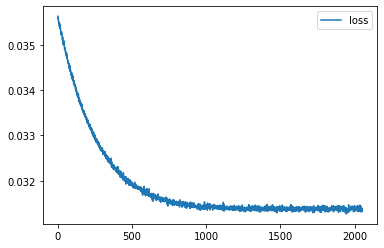

24.428571428571427
iteration: 2100 loss: 0.0313966408456591


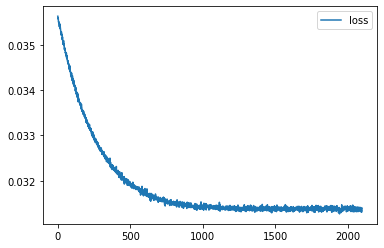

24.285714285714285
iteration: 2150 loss: 0.03137950239364396


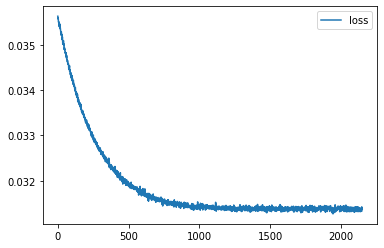

24.142857142857142
iteration: 2200 loss: 0.03141154247251424


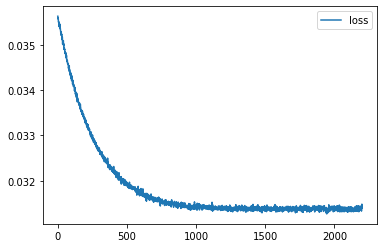

24.0
iteration: 2250 loss: 0.03141195987435905


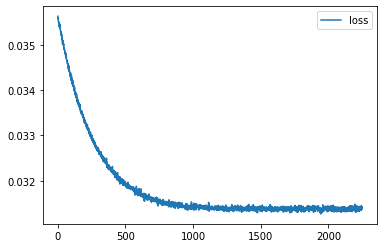

24.0
iteration: 2300 loss: 0.03136911268600009


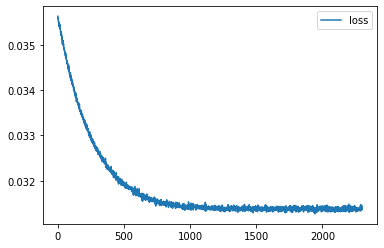

24.0
iteration: 2350 loss: 0.031390531242571094


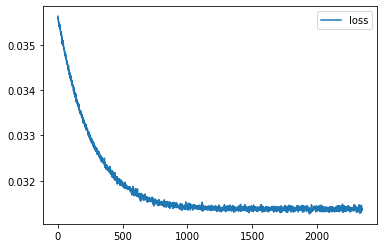

24.0
iteration: 2400 loss: 0.03134676538915797


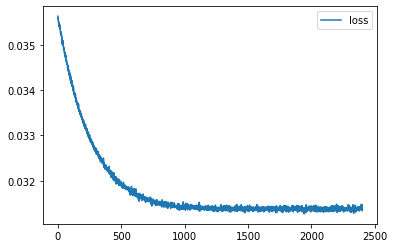

24.0
iteration: 2450 loss: 0.031327372416853905


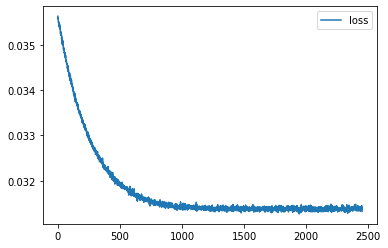

24.0
iteration: 2500 loss: 0.03139939104122194


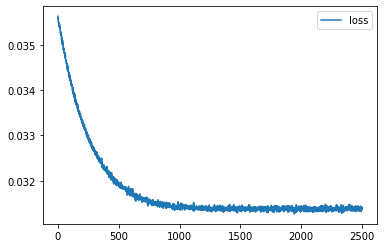

24.0
iteration: 2550 loss: 0.03136067685078491


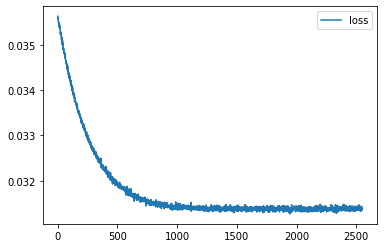

24.0
iteration: 2600 loss: 0.031359518370167774


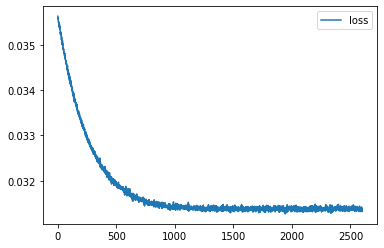

24.0
iteration: 2650 loss: 0.031373296229338106


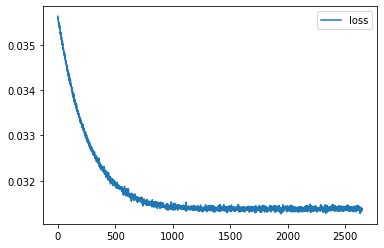

24.0
iteration: 2700 loss: 0.031361828981475395


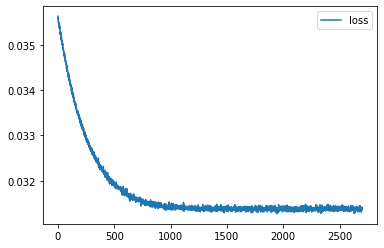

24.0
iteration: 2750 loss: 0.03134037025103515


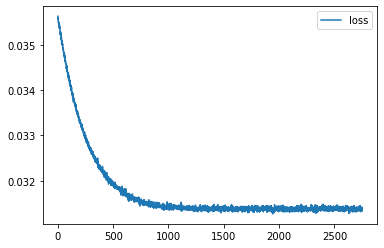

24.0
iteration: 2800 loss: 0.03128662989051505


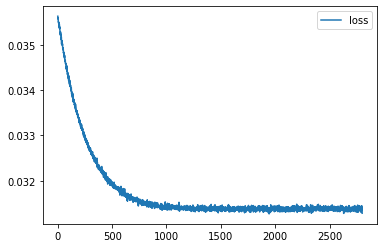

24.0
iteration: 2850 loss: 0.03142121967605569


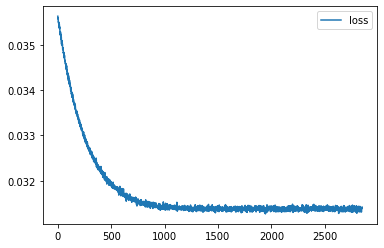

24.0
iteration: 2900 loss: 0.03143150664188645


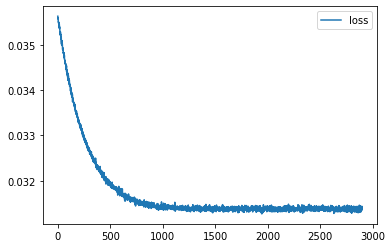

24.0
iteration: 2950 loss: 0.031348440584472635


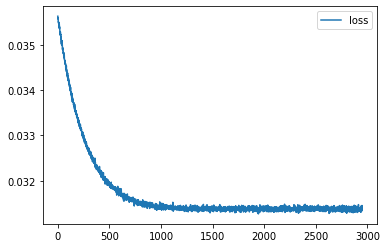

24.0
iteration: 3000 loss: 0.0314216552386907


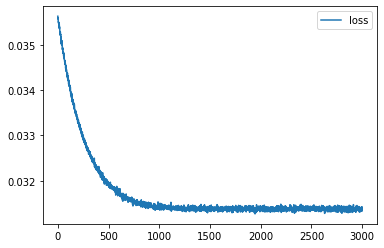

24.0
iteration: 3050 loss: 0.03133101054382595


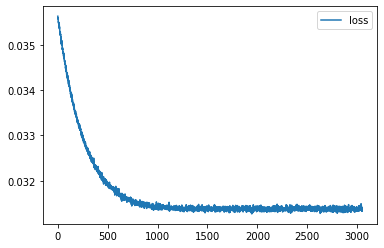

24.0
iteration: 3100 loss: 0.031341585076668045


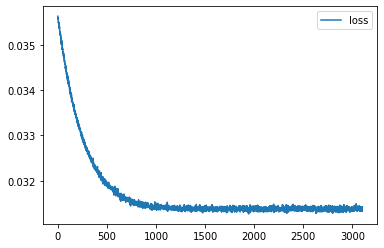

24.0
iteration: 3150 loss: 0.03134336356412281


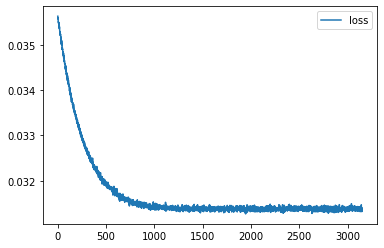

24.0
iteration: 3200 loss: 0.031386093363504515


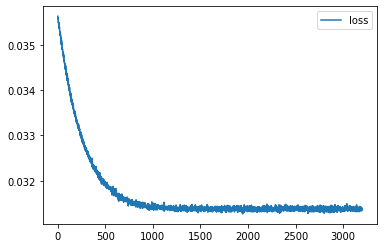

24.0
iteration: 3250 loss: 0.03135033768855713


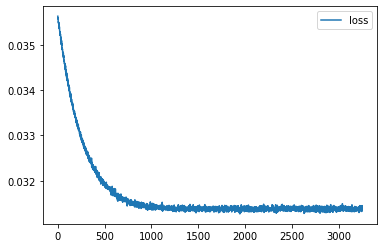

24.0
iteration: 3300 loss: 0.03139238216152245


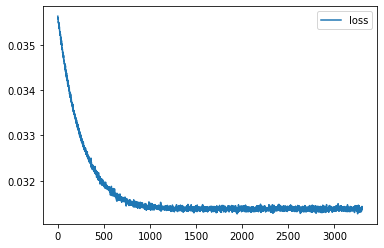

24.0
iteration: 3350 loss: 0.031378000805323776


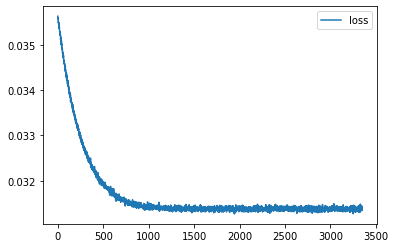

24.0
iteration: 3400 loss: 0.03139380001547662


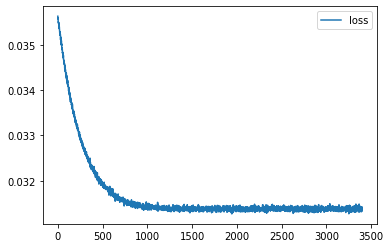

24.0
iteration: 3450 loss: 0.0313921085220169


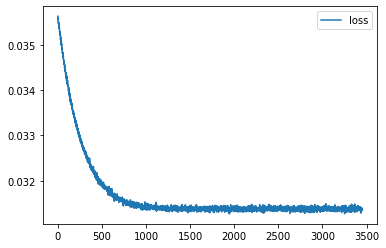

24.0
iteration: 3500 loss: 0.03133295675400983


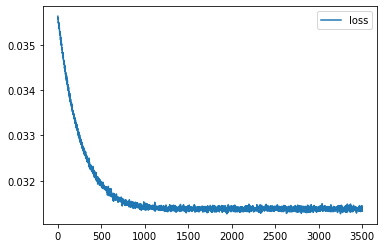

24.0
iteration: 3550 loss: 0.031344664325429636


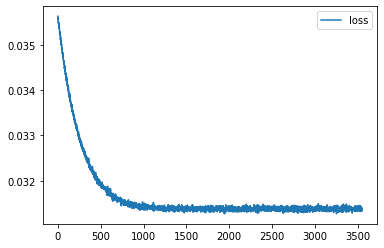

24.0
iteration: 3600 loss: 0.03137620737437497


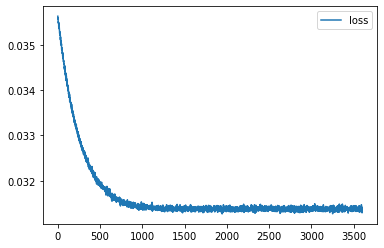

24.0
iteration: 3650 loss: 0.03138246869837696


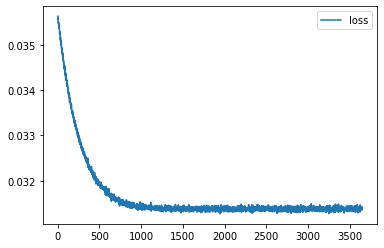

24.0
iteration: 3700 loss: 0.03141149903901599


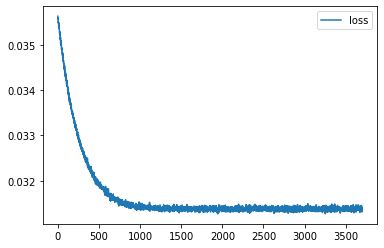

24.0
iteration: 3750 loss: 0.03138282577591864


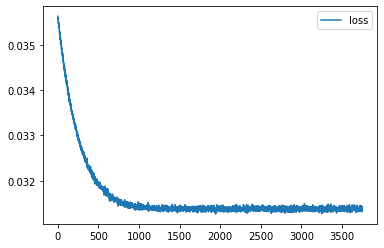

24.0
iteration: 3800 loss: 0.031408726280047136


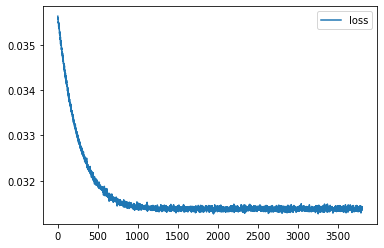

24.0
iteration: 3850 loss: 0.03138729472729293


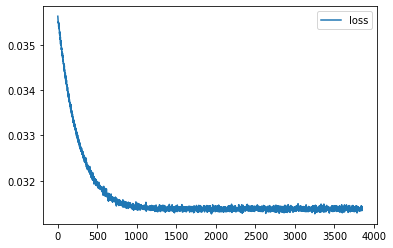

24.0
iteration: 3900 loss: 0.03146146259016611


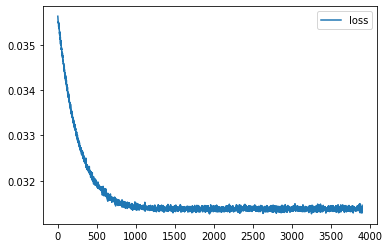

24.0
iteration: 3950 loss: 0.03133563714271242


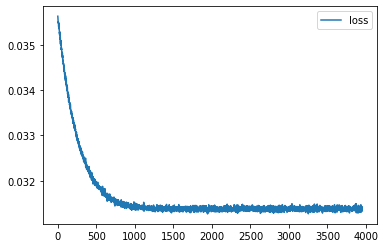

24.0
iteration: 4000 loss: 0.03147205917842009


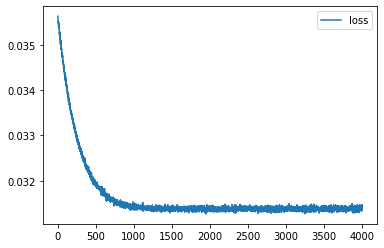

24.0
iteration: 4050 loss: 0.0314112761142579


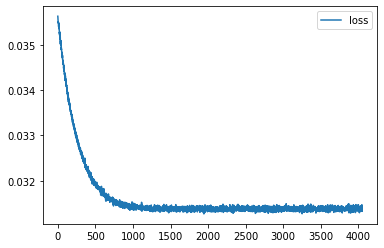

24.0
iteration: 4100 loss: 0.03135105285962874


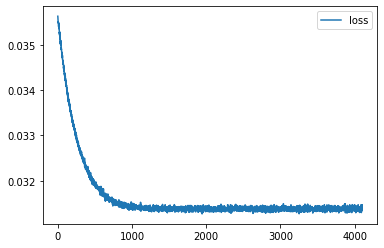

24.0
iteration: 4150 loss: 0.0313379699787633


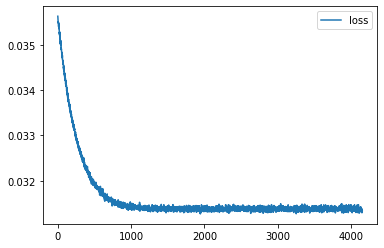

24.0
iteration: 4200 loss: 0.03134439441121437


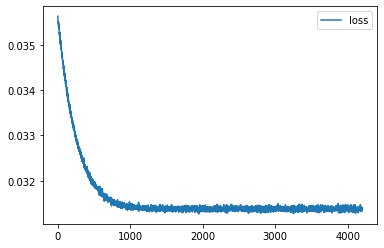

24.0
iteration: 4250 loss: 0.03134646342897957


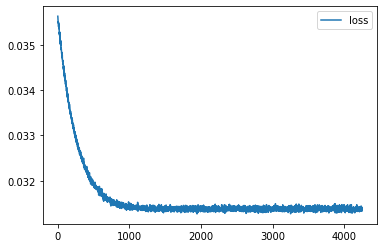

24.0
iteration: 4300 loss: 0.03137839682908221


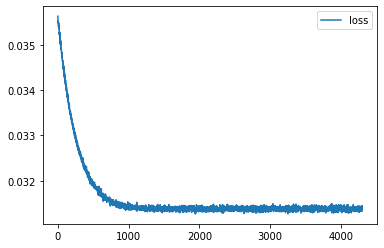

24.0
iteration: 4350 loss: 0.03136145378547636


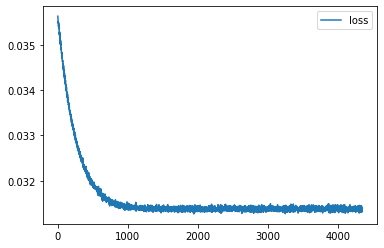

24.0
iteration: 4400 loss: 0.03137221288951961


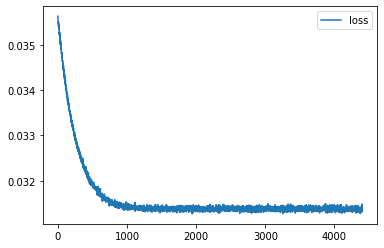

24.0
iteration: 4450 loss: 0.031326055865396156


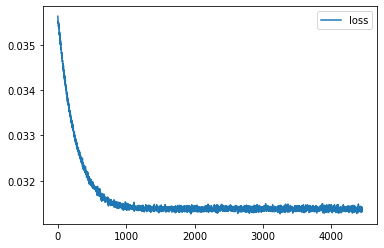

24.0
iteration: 4500 loss: 0.031375430736013434


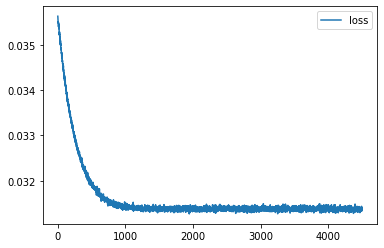

24.0
iteration: 4550 loss: 0.03137149158018557


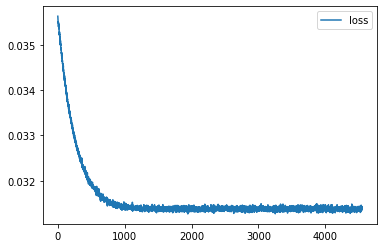

24.0
iteration: 4600 loss: 0.03136133385652846


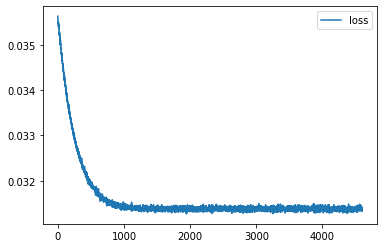

24.0
iteration: 4650 loss: 0.031426857140931214


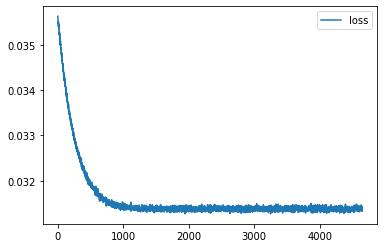

24.0
iteration: 4700 loss: 0.03140713985670696


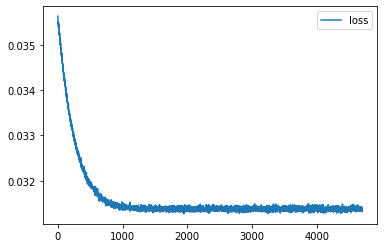

24.0
iteration: 4750 loss: 0.03135460428893566


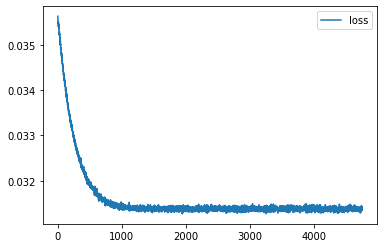

24.0
iteration: 4800 loss: 0.031368030573834076


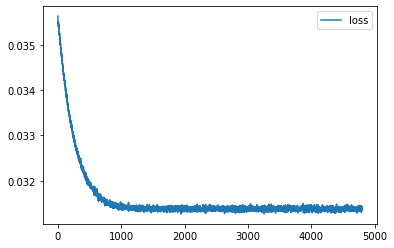

24.0
iteration: 4850 loss: 0.031386024953628126


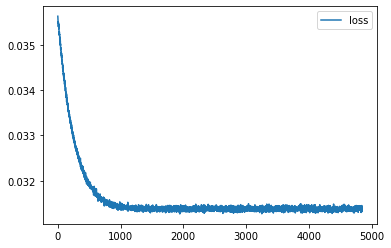

24.0
iteration: 4900 loss: 0.031356887595558706


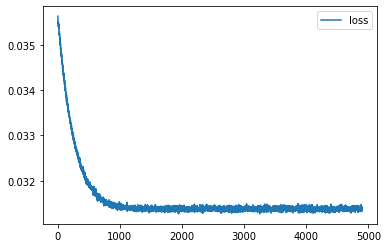

24.0


KeyboardInterrupt: 

In [30]:
trainer = SingleCudaTrainer(MlpRegression(param), use_gpu=param.use_gpu)
optimizer = torch.optim.Adadelta(trainer.model.parameters(), lr=param.lr)  # optimize all cnn parameters
loss_func = nn.MSELoss()
loss_list = []
acc_list = []
# epoch = 12000

for it in range(param.epoch):
    loss_batch = .0
    for idx, dda in enumerate(dataloader):
        x, y = SingleGpuTensorWrapper(dda[0], use_gpu=param.use_gpu), SingleGpuTensorWrapper(dda[1],
                                                                                             use_gpu=param.use_gpu)
        predict = trainer.model(x.tensor)
        # dbg('ok at it:', it)
        loss = loss_func(predict, y.tensor)  # calculate loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients
        loss_batch += loss.item()
    loss_list.append(loss_batch / len(dataloader))

    if it % 50 == 0:
        dbg('iteration:', it, 'loss:', loss_batch / len(dataloader), )
        plt.plot(loss_list, label='loss')
        plt.legend(loc='upper right')
        plt.show()

        predict=trainer.model(x1_gpu_wrapper.tensor)
        dif = predict.reshape(-1, ) - y1_gpu_wrapper.tensor
        percent=np.sum((np.abs(dif.cpu().detach().numpy()) < 0.025)) / len(dif) * 100
        dbg(percent)

dbg('train done')